In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import scipy
import scipy.stats as scs
import sys
import os



In [2]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from visualization import *
from plot import *

## Data Reading 

In [3]:
missing_values= ["n/a","na","undefined"]
df = pd.read_csv('../data/AdSmartABdata.csv')
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


#### Data Cleaning 

In [4]:
#Determining the users who responded to the ads

response_df = df.query("(yes == 1 or no == 1)")
response_df.shape[0]

1243

Out of the 8077 users, only 1243 responded to the questionnaire

In [5]:
#Getting clean data containing only users who responded alongside relevant columns for testing

clean_df = response_df[['auction_id', 'experiment', 'yes', 'no']]
clean_df

,auction_id,experiment,yes,no
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,0,1
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,1,0
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,0,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,1,0
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,0,1
...,...,...,...,...
8059,ffa08ff9-a132-4051-aef5-01a9c79367bc,exposed,1,0
8063,ffb176df-ecd2-45d3-b05f-05b173a093a7,exposed,1,0
8064,ffb79718-6f25-4896-b6b3-e58b80a6e147,control,0,1
8069,ffca1153-c182-4f32-9e90-2a6008417497,control,0,1


The rates of aware users in both the control and exposed groups are as shown in the yes column above

In [6]:
actual_counts = clean_df.pivot_table(index='experiment', aggfunc='sum')
actual_counts['total'] = clean_df.pivot_table(values='yes', index='experiment', aggfunc='count')
actual_counts


,no,yes,total
experiment,,,
control,322,264,586
exposed,349,308,657


The actual number of users aware and those not aware of the ad and the totals for each group

In [7]:
#Determining the number of users aware or not between the two groups to determine their conversion rates

conversion_rates = clean_df.pivot_table(index='experiment')
conversion_rates

,no,yes
experiment,,
control,0.549488,0.450512
exposed,0.531202,0.468798


## Binomial Distribution

In [8]:
# fig, ax = plt.subplots(figsize=(12,6))
# xA = np.linspace(A_converted-49, A_converted+50, 100)
# yA = scs.binom(A_total, p_A).pmf(xA)
# ax.bar(xA, yA, alpha=0.5)
# xB = np.linspace(B_converted-49, B_converted+50, 100)
# yB = scs.binom(B_total, p_B).pmf(xB)
# ax.bar(xB, yB, alpha=0.5)
# plt.xlabel('converted')
# plt.ylabel('probability')

The above is a template for drawing the binomial distribution for the null and alternative hypothesis

In [8]:
exposed_conversion_rate = conversion_rates['yes']['exposed']
control_conversion_rate = conversion_rates['yes']['control']
expose_aware = actual_counts['yes']['exposed']
control_aware = actual_counts['yes']['control']
exposed_total = actual_counts['total']['exposed']
control_total = actual_counts['total']['control']
difference = exposed_conversion_rate - control_conversion_rate

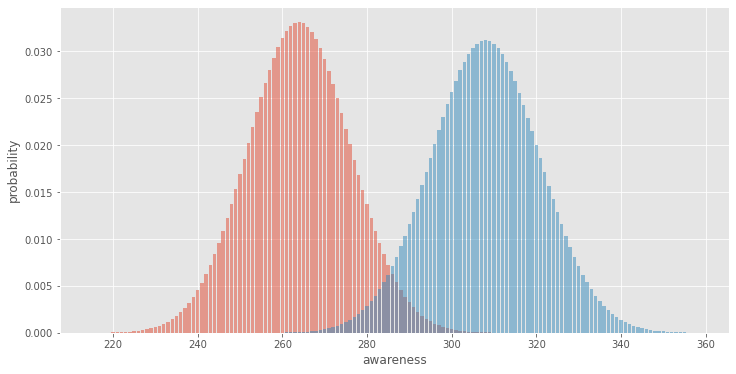

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

xC = np.linspace(control_aware - 49, control_aware + 50, 100)
yC = scs.binom(control_total, control_conversion_rate).pmf(xC)
ax.bar(xC, yC, alpha=0.5, linestyle='--')
xE = np.linspace(expose_aware - 49, expose_aware + 50, 100)
yE = scs.binom(exposed_total , exposed_conversion_rate).pmf(xE)
ax.bar(xE, yE, alpha=0.5, linestyle='--')
plt.xlabel('awareness')
plt.ylabel('probability')
plt.show()

The blue distribution is the probability of conversions for the control group , and the orange distributin is the probability of conversions for the exposed group. As we can see there is a difference in the mean of the two distributions.

## The means sample of the Distribution

In [10]:
# standard error of the mean

SE_C = np.sqrt(control_conversion_rate* (1- control_conversion_rate)) / np.sqrt(control_total)
SE_E = np.sqrt(exposed_conversion_rate * (1-exposed_conversion_rate)) / np.sqrt(exposed_total)

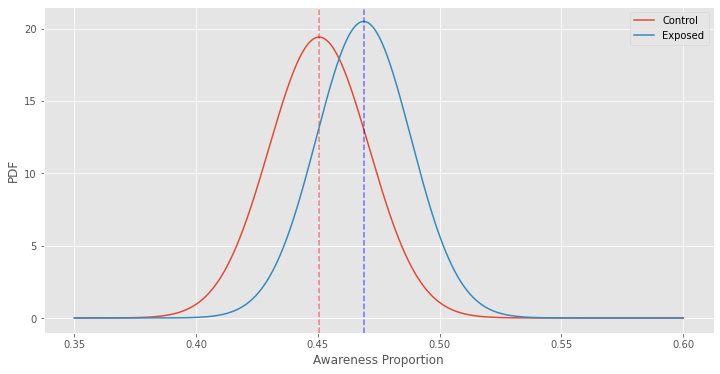

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.linspace(.35, .6, 1000)

yC = scs.norm(control_conversion_rate, SE_C).pdf(x)
ax.plot(x, yC, label='Control')
ax.axvline(x=control_conversion_rate, c='red', alpha=0.5, linestyle='--')

yE = scs.norm(exposed_conversion_rate, SE_E).pdf(x)
ax.plot(x, yE, label='Exposed')
ax.axvline(x=exposed_conversion_rate, c='blue', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('Awareness Proportion')
plt.ylabel('PDF')
plt.show()

The dashed vertical line which pass throught the peaks are the mean conversion rate for each group

In [13]:
std_cont = np.sqrt(control_conversion_rate * (1 - control_conversion_rate) / control_total)
std_exp = np.sqrt(exposed_conversion_rate * (1 - exposed_conversion_rate) / exposed_total)
std_cont, std_exp

(0.02055339057798332, 0.019468837373132736)

Now we have enough information to contstruct the distributions of the null hypothesis and alternative hypothesis.

#### Let's compare the null hypothesis vs. the alternative hypothesis 


H0: null hypothesis( no difference in brand awerness between the 2 groups)

H1: reject null hypothesis( there's a difference in brand awareness)


In [14]:
from plot import abplot

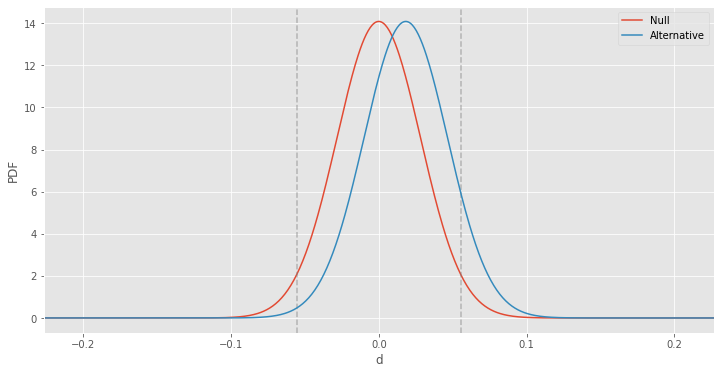

In [15]:
abplot(control_total, exposed_total, control_conversion_rate, difference)

we can see from the plot that the exposed group has a higher
convarsion rate than the control group

### Calculate the z-score and p- value

In [16]:
z_score = (difference) / np.sqrt(std_cont**2 + std_exp**2)
print(f"zscore is {z_score:0.5f}, with p-value {scs.norm().sf(z_score):0.5f}")

zscore is 0.64590, with p-value 0.25917


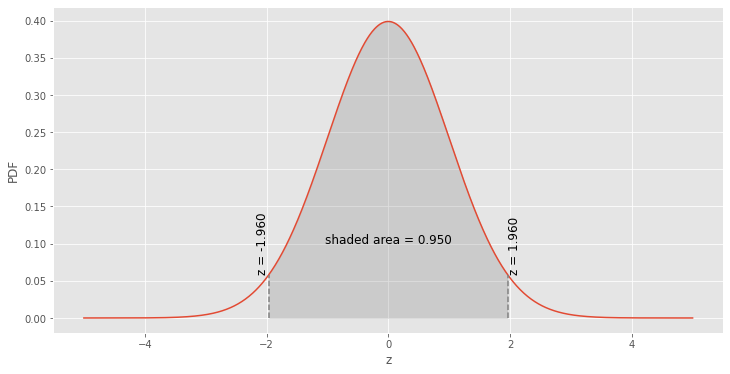

In [17]:
zplot(area=0.95)

we get p-value of 0.259 that is greater than 0.05(significance level)
so based on the p-value fail to reject the null hypothesis


### Statistical Power and Significance Level

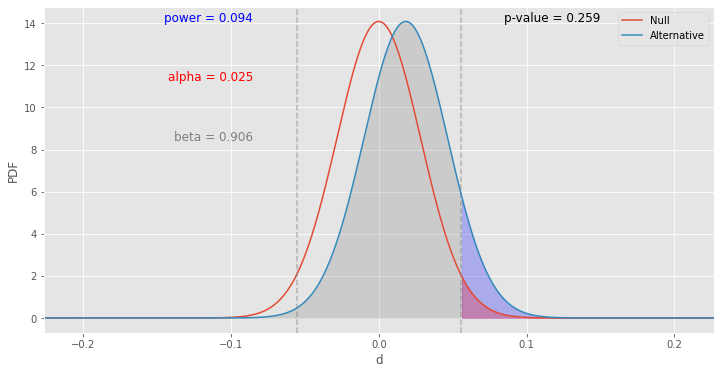

In [18]:
abplot(control_total, exposed_total, control_conversion_rate, difference, show_power=True, show_beta=True, show_alpha=True, show_p_value=True)

There is a small value of power size of 0.095. which is 9.5% probablity of not making a type-II error. this is not a good sign for accepting the out come of this test.
Beta value is the probability of making  a type -II error, 90.6% is hight probablity making a type-II error .
we get alpha value of 0.025 on the right tail and we get p-value of 0.259 which is greater than 0.05(significance level).
Based on the p-value we fail to reject the Null hypothesis.

But the distribution graph and power value we can understand that the sample size taken to condact this testing is very small. This indicate that there is high probability of making a type -II error. 
So we need more data to make a good conclusion from this testing.